# Final Project 
## Analysis of Subway usage of Seoul using based on signal processing 

### How things go:
+ Obtain temporal Seoul subway usage data
+ Extract features using fourier transformation (or wavelet transfomr)
+ Cluster based on similarity
+ Analyze the result based on urban context

### 1. Obtain temporal Seoul subway usage data
+ Data is retrieved from [http://data.seoul.go.kr/dataList/OA-12252/S/1/datasetView.do]

In [12]:
import pandas as pd
from datetime import datetime

In [48]:
raw_path = './Rawdata/서울시 지하철 호선별 역별 시간대별 승하차 인원 정보.csv'

raw_df = pd.read_csv(raw_path)
sample_df = raw_df[raw_df['사용월'] >= 202101]

In [53]:
start_times = [str(i).zfill(2)+'시-'+str(i+1).zfill(2)+'시 '  for i in range(4, 24)]
end_times = [str(i).zfill(2)+'시-'+str(i+1).zfill(2)+'시 '  for i in range(0, 4)]

times = start_times + end_times
in_times = [i + '승차인원' for i in times]
out_times = [i + '하차인원' for i in times]

col_names = ['사용월', '호선명','지하철역']
in_cols = col_names + in_times
out_cols = col_names + out_times
in_df = sample_df[in_cols]
out_df = sample_df[out_cols]

in_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2423 entries, 0 to 2422
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   사용월           2423 non-null   int64 
 1   호선명           2423 non-null   object
 2   지하철역          2423 non-null   object
 3   04시-05시 승차인원  2423 non-null   int64 
 4   05시-06시 승차인원  2423 non-null   int64 
 5   06시-07시 승차인원  2423 non-null   int64 
 6   07시-08시 승차인원  2423 non-null   int64 
 7   08시-09시 승차인원  2423 non-null   int64 
 8   09시-10시 승차인원  2423 non-null   int64 
 9   10시-11시 승차인원  2423 non-null   int64 
 10  11시-12시 승차인원  2423 non-null   int64 
 11  12시-13시 승차인원  2423 non-null   int64 
 12  13시-14시 승차인원  2423 non-null   int64 
 13  14시-15시 승차인원  2423 non-null   int64 
 14  15시-16시 승차인원  2423 non-null   int64 
 15  16시-17시 승차인원  2423 non-null   int64 
 16  17시-18시 승차인원  2423 non-null   int64 
 17  18시-19시 승차인원  2423 non-null   int64 
 18  19시-20시 승차인원  2423 non-null   int64 
 19  20시-21

In [150]:
#in_pivot = in_df.pivot(index = ['지하철역'], columns = '사용월' )
in_pivot = pd.pivot_table(in_df, index = ['지하철역', '사용월'])
#print(in_pivot)
test = in_pivot.stack()
in_pivot_df = test.to_frame('influx')
in_pivot_df.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 49776 entries, ('4.19민주묘지', 202101, '00시-01시 승차인원') to ('흑석(중앙대입구)', 202104, '23시-24시 승차인원')
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   influx  49776 non-null  float64
dtypes: float64(1)
memory usage: 588.4+ KB


In [242]:
in_pivot_df.index.get_level_values(1)
new = in_pivot_df.unstack(level = -3)
new2 = new.droplevel(0, axis = 1)
new3 = new2.droplevel(0)
new4 = new3.T
sample_station = new4.iloc[:5]
sample_station

#print(new[new['influx'] == '가락시장'])
#new.columns

,00시-01시 승차인원,01시-02시 승차인원,02시-03시 승차인원,03시-04시 승차인원,04시-05시 승차인원,05시-06시 승차인원,06시-07시 승차인원,07시-08시 승차인원,08시-09시 승차인원,09시-10시 승차인원,...,14시-15시 승차인원,15시-16시 승차인원,16시-17시 승차인원,17시-18시 승차인원,18시-19시 승차인원,19시-20시 승차인원,20시-21시 승차인원,21시-22시 승차인원,22시-23시 승차인원,23시-24시 승차인원
지하철역,,,,,,,,,,,,,,,,,,,,,
4.19민주묘지,0.0,0.0,0.0,0.0,0.0,1078.0,2276.0,6008.0,6823.0,4620.0,...,5162.0,5928.0,6186.0,5670.0,5116.0,2922.0,2115.0,1626.0,1069.0,282.0
가능,42.0,0.0,0.0,0.0,266.0,5869.0,8856.0,18892.0,17044.0,9585.0,...,8001.0,8504.0,9195.0,10832.0,9026.0,5589.0,4348.0,3706.0,3118.0,757.0
가락시장,3.0,0.0,0.0,0.0,14.0,2180.5,5082.0,11588.0,14056.0,9563.5,...,12052.5,13252.0,14048.0,18301.5,28630.0,11833.5,9157.5,9730.0,8087.0,1257.5
가산디지털단지,36.0,0.5,0.0,0.0,682.0,6327.0,6978.0,14110.0,15710.5,10913.0,...,25105.0,30637.5,44116.5,124307.5,222608.0,93583.0,49761.0,44481.0,28099.0,4600.5
가양,0.0,0.0,0.0,0.0,46.0,11547.0,19095.0,55488.0,58491.0,31783.0,...,23729.0,24855.0,28661.0,34018.0,41239.0,19210.0,13011.0,11657.0,8836.0,1624.0


-----------------------
00시-01시 승차인원       0.0
01시-02시 승차인원       0.0
02시-03시 승차인원       0.0
03시-04시 승차인원       0.0
04시-05시 승차인원       0.0
                 ...  
19시-20시 승차인원    2922.0
20시-21시 승차인원    2115.0
21시-22시 승차인원    1626.0
22시-23시 승차인원    1069.0
23시-24시 승차인원     282.0
Name: 4.19민주묘지, Length: 96, dtype: float64
-----------------------
00시-01시 승차인원      42.0
01시-02시 승차인원       0.0
02시-03시 승차인원       0.0
03시-04시 승차인원       0.0
04시-05시 승차인원     266.0
                 ...  
19시-20시 승차인원    5589.0
20시-21시 승차인원    4348.0
21시-22시 승차인원    3706.0
22시-23시 승차인원    3118.0
23시-24시 승차인원     757.0
Name: 가능, Length: 96, dtype: float64
-----------------------
00시-01시 승차인원        3.0
01시-02시 승차인원        0.0
02시-03시 승차인원        0.0
03시-04시 승차인원        0.0
04시-05시 승차인원       14.0
                 ...   
19시-20시 승차인원    11833.5
20시-21시 승차인원     9157.5
21시-22시 승차인원     9730.0
22시-23시 승차인원     8087.0
23시-24시 승차인원     1257.5
Name: 가락시장, Length: 96, dtype: float64
-----------------------
00시-01시 승차인원   

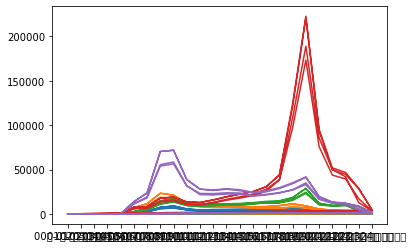

In [244]:
plt.clf()
for k, v in enumerate(sample_station.iterrows()):
    print('-----------------------')
    print(v[1])
    plt.plot(v[1])
plt.show()